# Networking for Big Data - Project
- Jonas Barth 2050678
- Susanna Bravi 1916681
- Eric Rubia Aguilera 2049558

In [23]:
import pyshark
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy
import sys
import shutil
import os
import plotly.express as px
from plotly.subplots import make_subplots
from functools import reduce

# Part A
#### 1. Extract general info from your trace using capinfos

In [ ]:
!capinfos -A _00000_20190410070000.pcap

#### 2. Time Evaluation between Sequential and Parallel reading

We evaluate the time taken to process `.pcap` file sequentially and parallely as a function of the number of packets in the `.pcap` file. This allows us to show how the processing time scales with the number of packets. We initially used the `pyshark` library, however since it proved to be too slow to allow for a fast turnaround, we decided to use the `scapy` library instead which offers a similar functionality to `pyshark` but with better speed. Each processing algorithm is timed once, using Python's `timeit` package.
   
The [read.py](read.py) script lets you time either a sequential or parallel algorithm for a single `.pcap` file. The results are stored in a `.feather` file.,

We run the processing for the following number of packets:,

* 10
* 100
* 1000
* 10000
* 100000
* 1000000

##### Sequential Processing,
The sequential processing, opens the `.pcap` file, reads the packets one by one into domain objects, creates a dataframe, and closes the file.,

##### Parallel Processing,
The parallel processing algorithm first divides the given `.pcap` file into $n$ smaller `.pcap` files of $p$ packets each. Then, a maximum of $m$ processes are started in parallel, each of which processes a single `.pcap` file sequentially. The number of parallel processes is capped at the parameter $m$ as not to overwhelm the available computing resources.,

#### Results,
The sequential and parallel processing algorithms were run once for each `.pcap` file. The line plot below shows the processing time in seconds for the number of packets in the `.pcap` files. For files with a number of packets $\\le 10000$, the parallel and sequential reading takes more or less the same amount of time. For the largest file of $1000000$ packets, the parallel processing is much faster than the sequential processing.,

With parallel processing, there is some overhead in splitting the original file and starting the processes, hence we can expect that the pay off of parallel processing to be insignificant for a small number of packets.

First, we combine all the different measurement dataframes into a single one

In [ ]:
timing_df = reduce(lambda a, b: pd.concat((a, b), axis=0, ignore_index=True), map(lambda df_path: pd.read_feather(df_path), glob.glob("data/timing_results/*.feather")))
parallel_times = timing_df[timing_df.read_type == 'parallel']
sequential_times = timing_df[timing_df.read_type == 'sequential']

Then we plot.

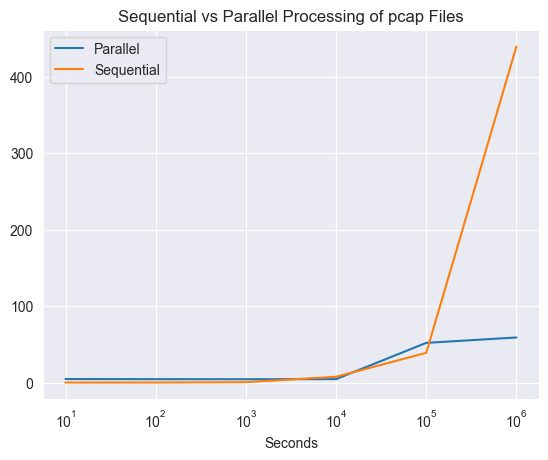

In [27]:
n = parallel_times.shape[0]
plt.plot(parallel_times.n_packets, parallel_times.time_s, label="Parallel")
plt.plot(sequential_times.n_packets, sequential_times.time_s, label="Sequential")
plt.xticks([10**i for i in range(1, n + 1)], [f"$10^{i}$" for i in range(1, n + 1)])
plt.legend()
plt.xscale("log")
plt.xlabel("Number of Packets")
plt.ylabel("Seconds")
plt.title("Sequential vs Parallel Processing of pcap Files")
plt.show()

#### 3. Extract the IP which generates the highest amount as sender traffic, evaluate the bit rate (0.1 sec) for the 6 IP addresses mostly used as endpoint


In [ ]:
# It takes about 2 minutes (or more) to import the pkl file
dataFrame = pd.read_feather("packets.feather")
len(dataFrame)

In [ ]:
dataFrame

In [ ]:
#dataFrame.head()
source = dataFrame.groupby(["IP_SRC"])
len(source) #we have 4548 different sources
# what is the source that sends more pckts?

In [ ]:
data_couple = dataFrame.groupby(["IP_SRC"])[['length']].agg('sum')
print(data_couple.sort_values(by=['length'], ascending=False).head(10))

In [ ]:
max = data_couple.max()
print(data_couple.loc[data_couple['length'] == int(max.iloc[0])])
#so maybe the ip source that generates more traffic is 150.57.136.251

In [ ]:
onlyTheSource = dataFrame[dataFrame["IP_SRC"] == "150.57.136.251"]

data_destination = onlyTheSource.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(6)

data_6IPs = onlyTheSource.groupby(["IP_DST"])
print(data_destination)

rowlength = int(data_destination.shape[0]/2)


In [ ]:
fig = px.histogram(dataFrame["length"], x='length',
                   nbins=15, 
                   title='Histogram of Packet Length',
                   labels={'length':'Packet Length (Byte)'},
                   opacity=0.8,
                   log_y=False,
                   color_discrete_sequence=['#2a9d8f'],
                   text_auto=True,
                   template='plotly_white',
                   width=800, 
                   height=400)
fig.update_layout(
    yaxis_title_text='Frequency',
    bargap=0.2, # gap between bars of adjacent location coordinates
    #margin=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="gray"
)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)
fig.show(renderer='notebook')

In [39]:
def bitRate(data, step_sec = 0.1):
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    
    data["time"] -= data.iloc[0]["time"]
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    step = finish/ step_sec
    finish = start + step_sec
    value = []
    #print(step)
    for i in range(int(step)):
    
        #From Byte to bit - selection of the time interval between the start and the end of a single time slot
        val = np.sum(data[(data["time"]>=start) & (data["time"]<finish)]["length"]*8)
        if not np.isnan(val):
            value.append(val/step_sec)
        start = finish 
        finish = start + step_sec
        
    return value


In [ ]:
fig, axs = plt.subplots(figsize=(20,12), 
                        nrows=2, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 
#fig.tight_layout()
targets = zip(data_destination.index, axs.flatten())
for i, (key, ax) in enumerate(targets):
    print(key)
    #ax.plot(data_couple.get_group(key)["length"])
    ax.plot(bitRate(data_6IPs.get_group(key)),marker = "o")
    ax.set_title(key)
    ax.set_xlabel("T (sec)")
    ax.set_ylabel("bit/sec")
    #ax.set_yscale('log')
ax.legend()
fig.suptitle('TOP 6 IP Dst for 150.57.136.251', fontsize=16)
#plt.savefig("TOP 6 IP Dst for MyIP")
plt.show()

#If now the step in bit rate is 0.1 second, the label of the x axes remains in seconds?

#### 4. Top 5 Destination IP (received bytes) and Top 5 Source IP (sent bytes)


In [ ]:
data_top5dest = dataFrame.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(5)
data_top5dest

In [ ]:
bar_dest = px.bar(data_top5dest, y=data_top5dest.index[:], x = data_top5dest['length'][:]/1e3,
                    title='Top 5 destinations',
                    opacity=0.8,
                    color_discrete_sequence=['#e5b769'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_dest.update_layout(
    yaxis_title_text ='Destinations',
    xaxis_title_text ='Received Bytes')# gap between bars of adjacent location coordinates
bar_dest.update_yaxes(tickfont_family="Arial Black")
bar_dest.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)



In [ ]:
data_top5source = data_couple.sort_values(by=['length'], ascending=False).head(5)

In [ ]:
bar_source = px.bar(data_top5source, y=data_top5source.index[:], x = data_top5source['length'][:]/1e3,
                    title='Top 5 sources',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_source.update_layout(
    yaxis_title_text ='Sources',
    xaxis_title_text ='Bytes Sent')
bar_source.update_yaxes(tickfont_family="Arial Black")
bar_source.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

#### 5. Evaluate bitRate considering all the trace with 3 different sampling rate

In [54]:
bit_plot = px.line(dataFrame,
              x=[ i*0.1 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))))+1)],
              y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))),
              template='plotly_white',
              title='Total bit rate',
              markers=True)
bit_plot.update_legends
bit_plot['data'][0]['showlegend'] = True
bit_plot['data'][0]['name'] = '0.1 sec'
bit_plot.add_scatter(x=[ i*0.4 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))),name="0.4 sec")
bit_plot.add_scatter(x=[ i*0.8 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))),name="0.8 sec")
bit_plot.update_layout(
    yaxis_title_text ='Mbps',
    xaxis_title_text ='Time(s)')


#### 6. GeoLocal Referenciation of the 5 sessions with the highest amount of traffic generated

In [ ]:
from ip2geotools.databases.noncommercial import DbIpCity
import folium

In [ ]:
def geo_infos(ip_src_list, ip_dst_list):

  src_geo_info = []
  dst_geo_info = []
  i = 0

  for j in range(len(ip_src_list)):
    try:
      src_response = DbIpCity.get(ip_src_list[j], api_key='free')
      dst_response = DbIpCity.get(ip_dst_list[j], api_key='free')
    except:
      continue
    if src_response.latitude == None or dst_response.latitude == None: 
      continue
    i +=1
    src_geo_info.append([src_response.latitude, src_response.longitude, src_response.region])
    dst_geo_info.append([dst_response.latitude, dst_response.longitude, dst_response.region])
    if i == 10: break

  return src_geo_info, dst_geo_info


In [ ]:
data_couple = copy.deepcopy(dataFrame)
#Change your local IP with the one used to navigate on the Web
#data_couple["IP_SRC"]= data_couple["IP_SRC"].replace({'192.168.43.28':'46.37.14.27'})
#data_couple["IP_DST"] = data_couple["IP_DST"].replace({'192.168.43.28':'46.37.14.27'})
df_srcdst = list(zip(data_couple.IP_SRC, data_couple.IP_DST))

mostcommon_srcdst = Counter(df_srcdst).most_common(5)
mostcommon_srcdst

In [ ]:
list_src = []
list_dst = []

for i in range(len(mostcommon_srcdst)):
    list_src.append(mostcommon_srcdst[i][0][0]) #src pos 0
    list_dst.append(mostcommon_srcdst[i][0][1]) #dst pos 1

#src_geo, dst_geo = geo_infos(list(top_10_flows['ip_src']), list(top_10_flows['ip_dst']))

#Sigle Couple
#src_geo, dst_geo = geo_infos(['185.86.84.30'],['46.37.14.27'])
#5 Couples
src_geo, dst_geo = geo_infos(list_src, list_dst)

src_geo = pd.DataFrame(src_geo, columns=['latitude', 'longitude', 'region'])
dst_geo = pd.DataFrame(dst_geo, columns=['latitude', 'longitude', 'region'])

print("Data:  \n")
print(src_geo)
print()
print(dst_geo)
print("\n")

flow_map = folium.Map([0, 0], zoom_start=2, tiles='Stamen Terrain')

for i in range(len(src_geo)):
  folium.Marker([src_geo.loc[i][0], src_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>', 
                icon=folium.Icon(color='green')).add_to(flow_map)
  folium.Marker([dst_geo.loc[i][0], dst_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>',  
                icon=folium.Icon(color='red')).add_to(flow_map)
  folium.PolyLine([(src_geo.loc[i][0], src_geo.loc[i][1]), (dst_geo.loc[i][0], dst_geo.loc[i][1])], 
                  color="blue", weight=1.5, opacity=1).add_to(flow_map)

#flow_map.save(folder_image +"Map_top_5_flows.html")
#display(flow_map)

#### 7. 10 Protocol mostly used

In [ ]:
grouped_flows = dataFrame.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
print(grouped_flows)

In [ ]:
grouped_flows.Protocol.value_counts().index #we have only 9 protocols??

In [ ]:
grouped_flows["Protocol"] = grouped_flows["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP",50:"ESP",4:"IPv4",47:"GRE",89:"OSPFIGP",97:"ETHERIP",103:"PIM"}) 
#like this util we do not found the name of the other protocols
#found them in https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

In [ ]:
bar_protocol = px.bar(grouped_flows["Protocol"], y=grouped_flows.Protocol.value_counts().index, x = grouped_flows.Protocol.value_counts().values,
                    title='Top 9 Protocols used',
                    opacity=0.8,
                    color_discrete_sequence=['#2a9d8f'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)

bar_protocol.update_layout(
    yaxis_title_text ='Prtocols',
    xaxis_title_text ='Count')
bar_protocol.update_yaxes(tickfont_family="Arial Black")
bar_protocol.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

### 8. Port Scanner evaluation (10 Ports mostly used)

In [ ]:
def port_scan (x, dic):
    ''' scan through the ports and update the counter at each import file. 
    save only the info for the well-known ports '''
    for port in x:
        if pd.isnull(port) == False:
            #Well-Known Ports
            if int(port) < 1024:
                if port not in dic.keys():
                    dic[port] = 1
                else:
                    dic[port] += 1
    return(dic)

In [ ]:
#Scanning port analysing pandasDataframe, both for source and destination ports
source_ports = {}
source_ports = port_scan(dataFrame["src_port"], source_ports)
dest_ports = {}
dest_ports = port_scan(dataFrame["dst_port"], dest_ports)

pd.DataFrame.from_dict(source_ports, orient = 'index').to_json('./source_ports.json')
pd.DataFrame.from_dict(dest_ports, orient = 'index').to_json('./dest_ports.json')

sports = pd.read_json('./source_ports.json')
dports = pd.read_json('./dest_ports.json')

sports = sports.reset_index()
dports = dports.reset_index()
sports = sports.rename(columns = {'index':'port', 0:'count'})
dports = dports.rename(columns = {'index':'port', 0:'count'})

sports = sports.sort_values(by = 'count', ascending = False)
dports = dports.sort_values(by = 'count', ascending = False)

In [ ]:
#PROBLEM ?
dports.port.value_counts().index #who is -1 ???

In [ ]:
#dports['port']=dports['port'].astype('string')
dports_10 = dports.sort_values(by=['count'], ascending=False).head(10)
dports_10["port"] = dports_10["port"].replace({443:"443 - HTTPS",80:"80 - HTTP",-1:"-1",53:"53 - DNS",873:"873 - rsync",993:"993 - IMAP4",22:"22 -SSH",161:"161 - SNMP ",25:"25 - SMTP",123:"123 - NTP"}) 
#sports['port']=sports['port'].astype('string')
sports_10 = sports.sort_values(by=['count'], ascending=False).head(10)
sports_10["port"] = sports_10["port"].replace({443:"443 - HTTPS",80:"80 - HTTP",-1:"-1",53:"53 - DNS",873:"873 - rsync",993:"993 - IMAP4",22:"22 -SSH",161:"161 - SNMP ",25:"25 - SMTP",123:"123 - NTP"}) 

In [ ]:
port_plot = px.bar(dports_10,x=dports_10['port'],y=dports_10['count'],text_auto=True,
                    title='Top 10 Destination ports used',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    template='plotly_white',
                    width=800, 
                    height=400)
'''
port_plot.update_layout(
    yaxis_title_text ='Ports',
    xaxis_title_text ='Count')
port_plot.update_xaxes(tickfont_family="Arial Black")
port_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'''

In [ ]:
sport_plot = px.bar(sports_10,x=sports_10['port'],y=sports_10['count'],text_auto=True,
                    title='Top 10 Source ports used',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    template='plotly_white',
                    width=800, 
                    height=400)
'''
sport_plot.update_layout(
    yaxis_title_text ='Ports',
    xaxis_title_text ='Count')
sport_plot.update_xaxes(tickfont_family="Arial Black")
sport_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'''

In [ ]:
#maybe we prefer them together?
fig = make_subplots(rows=1, cols=2,subplot_titles=("Destination Ports", "Source Ports"),shared_yaxes=True)
fig.add_trace(port_plot['data'][0], row=1, col=1)
fig.add_trace(sport_plot['data'][0], row=1, col=2)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="10 most used ports",
    xaxis_title_text ='Ports',
    yaxis_title_text ='Count')
fig.update_layout(template='plotly_white')
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_xaxes(title_text="ports", row=1, col=2)
fig.update_yaxes(title_text="count", row=1, col=2)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

In [ ]:
#we prefer something like this?? (me not :) )
plt.figure(figsize = (19, 10), dpi = 75)
plt.bar(x = list(map(str, list(sports.loc[sports['count'] > 50,'port']))), color = 'darkred', height = list(sports.loc[sports['count'] > 50,'count']), label = 'Src port', alpha = 0.7)
plt.bar(x = list(map(str, list(dports.loc[dports['count'] > 50,'port']))), color = 'darkcyan', height = list(dports.loc[dports['count'] > 50,'count']), label = 'Dst port', alpha = 0.7)
plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Ports with more than 50 occurrences', fontsize = 30, pad = 15)
plt.xlabel('Port number', fontsize = 20, labelpad = 15)
plt.ylabel('Count (logscale)', fontsize = 20, labelpad = 15)
#plt.savefig(folder_image +"Port Scanner")
plt.show()


### 9. InterArrival Time boxplot between TCP and UDP Sessions

In [ ]:
import copy
from collections import Counter

def InterArrivalTime(data):
    val = np.array(data["time"])
    #Calculate the n-th discrete difference along the given axis
    return np.diff(val)

data_protocol = copy.deepcopy(dataFrame[dataFrame["Protocol"].isin([6,17])])
data_protocol["Protocol"] = data_protocol["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP"})

print(Counter(data_protocol["Protocol"]))

In [ ]:
box_len = px.box(data_protocol, y="length", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#Seems like we have small pkts
#From the histogram at the beginning of the document we can see that almost all the pkts are < 2000 byte
#Let's try to do for only pkts of this size

In [ ]:
data_protocol_2000 = data_protocol[data_protocol["length"]<= 2000]
box_len_2000 = px.box(data_protocol_2000, y="length", x='Protocol', color='Protocol',template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
# The TCP box is quite big so the interquantile range is large... so we have data that is quite variable
# The UDP's box is smaller that the TCP one so here the variance is smaller and also the size of the pckts is smaller that the TCP. UDP also does not have pckts pf size bigger that 1500 byte while TCP has
# a median equal to 1299 so the 50% of the pckts are bigger taht 1300 bytes.

In [ ]:
np.quantile(np.array(data_protocol['length']),q=0.88)

In [ ]:
fig = make_subplots(rows=1, cols=4,subplot_titles=("Original data UDP","Original data TCP", "Pckts whit length < 2000 bytes UDP","Pckts whit length < 2000 bytes TCP"))
fig.add_trace(box_len['data'][0], row=1, col=1)
fig.add_trace(box_len['data'][1], row=1, col=2)
fig.add_trace(box_len_2000['data'][0], row=1, col=3)
fig.add_trace(box_len_2000['data'][1], row=1, col=4)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="Packets length")
fig.update_layout(template='plotly_white',showlegend=False)

In [ ]:
soloUDP = data_protocol[data_protocol["Protocol"]=='UDP']
np.max(np.array(soloUDP['length']))
#no UDP pckts bigger than 1500 bytes.. 
#maybe we should know why from the theory? 

In [ ]:
#Inter arrival time
tcp_data = data_protocol_2000[data_protocol_2000["Protocol"]=="TCP"]
udp_data = data_protocol_2000[data_protocol_2000["Protocol"]=="UDP"]

inteArr_TCP= []
for elem in tcp_data.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']):
    #groupby tuple (key,dataframe)
    inteArr_TCP += InterArrivalTime(elem[1]).tolist()

inteArr_UDP = []
for elem in udp_data.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']):
    inteArr_UDP += InterArrivalTime(elem[1]).tolist()


val_ = inteArr_TCP + inteArr_UDP

label_TCP = [ "TCP" for i in range(len(inteArr_TCP))]
label_UDP =[ "UDP" for i in range(len(inteArr_UDP))]

lab_ = label_TCP + label_UDP

d = {'Protocol': lab_, 'IntArrTime': val_}
df = pd.DataFrame(data=d)

In [ ]:
print("Mean InterArrivalTime TCP Session: %.4f"% np.mean(np.array(inteArr_TCP)))
print("Mean InterArrivalTime UDP Session: %.4f"% np.mean(np.array(inteArr_UDP)))
#the TCP interarrival time is smaller than the UDP
#median?
print("Median InterArrivalTime TCP Session: %.5f"% np.median(np.array(inteArr_TCP)))
print("Median InterArrivalTime UDP Session: %.5f"% np.median(np.array(inteArr_UDP)))
# 3rd quartile
print("3rd quartile InterArrivalTime TCP Session: %.5f"% np.quantile(np.array(inteArr_TCP),q=0.75))
print("3rd quartile InterArrivalTime UDP Session: %.5f"% np.quantile(np.array(inteArr_UDP),q=0.75))
#After this make sense to plot it for values less that 0.00004 (median of TCP) seconds and 0.0009 (median of UDP)

In [ ]:
df1 = df[df["IntArrTime"] <  0.0009]
fig1 = px.box(df1, y="IntArrTime", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#fig.show()

In [ ]:
df2 = df[df["IntArrTime"] < 0.00004]
fig2 = px.box(df2, y="IntArrTime", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=4,subplot_titles=("UDP < 0.009 s","TCP < 0.009 s", "UDP < 0.00004","TCP < 0.00004"))
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig1['data'][1], row=1, col=2)
fig.add_trace(fig2['data'][0], row=1, col=3)
fig.add_trace(fig2['data'][1], row=1, col=4)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="Interarrival time",
    yaxis_title_text='Time (s)')
fig.update_layout(template='plotly_white',showlegend=False)

### 10. Develope your own analysis (e.g. Topology of the network using networkx or evaluation about a variable such as TTL) 